# Show how we can inject a pulse into a GREENBURST filterbank.

In [1]:
import tempfile
from urllib import request

import matplotlib.pyplot as plt
import numpy as np
from jess.fitters import median_fitter
from scipy.stats import median_abs_deviation
from will import create, inject
from your import Your

In [2]:
def show_dynamic(dynamic_spectra: np.ndarray, title: str = None, save: bool = False):
    """
    Show a dynamic spectra by first flattening it
    in frequency. Do this by getting the medians of
    each channel and then run a median filter along the
    bandpass.

    Then set the limits of the imshow so we get good detail
    for the majority of the data.

    Args:
        dynmaic_spectra - the dynamic spectra to plot

        title - Title of plot

        save - Save the plot as `title` + `.png`
    """
    spectra_mads = median_fitter(np.median(dynamic_spectra, axis=0))
    flat = dynamic_spectra - spectra_mads
    std = median_abs_deviation(flat, axis=None)
    med = np.median(flat)
    plt.figure(figsize=(20, 10))
    plt.imshow(flat.T, vmin=med - 3 * std, vmax=med + 6 * std)
    plt.xlabel("Time Sample #", size=20)
    plt.ylabel("Channel #", size=20)
    plt.colorbar()
    plt.tight_layout()
    if title is not None:
        plt.title(title, size=28)
    if save:
        plt.savefig(title + ".png", dpi=200)

## Get a pulse search mode file

In [3]:
# Get a 33MB filbterbank from zenodo, put it in
# a temp directory
temp_dir = tempfile.TemporaryDirectory()
empty_fil = temp_dir.name + "/empty_example.fil"
request.urlretrieve(
    "https://zenodo.org/record/5860557/files/empty_example.fil", empty_fil
)

('/tmp/tmp7_q5hs5j/empty_example.fil',
 <http.client.HTTPMessage at 0x7fefac792d00>)

In [4]:
yr_obj = Your(empty_fil)
dynamic_spectra = yr_obj.get_data(0, 8192)

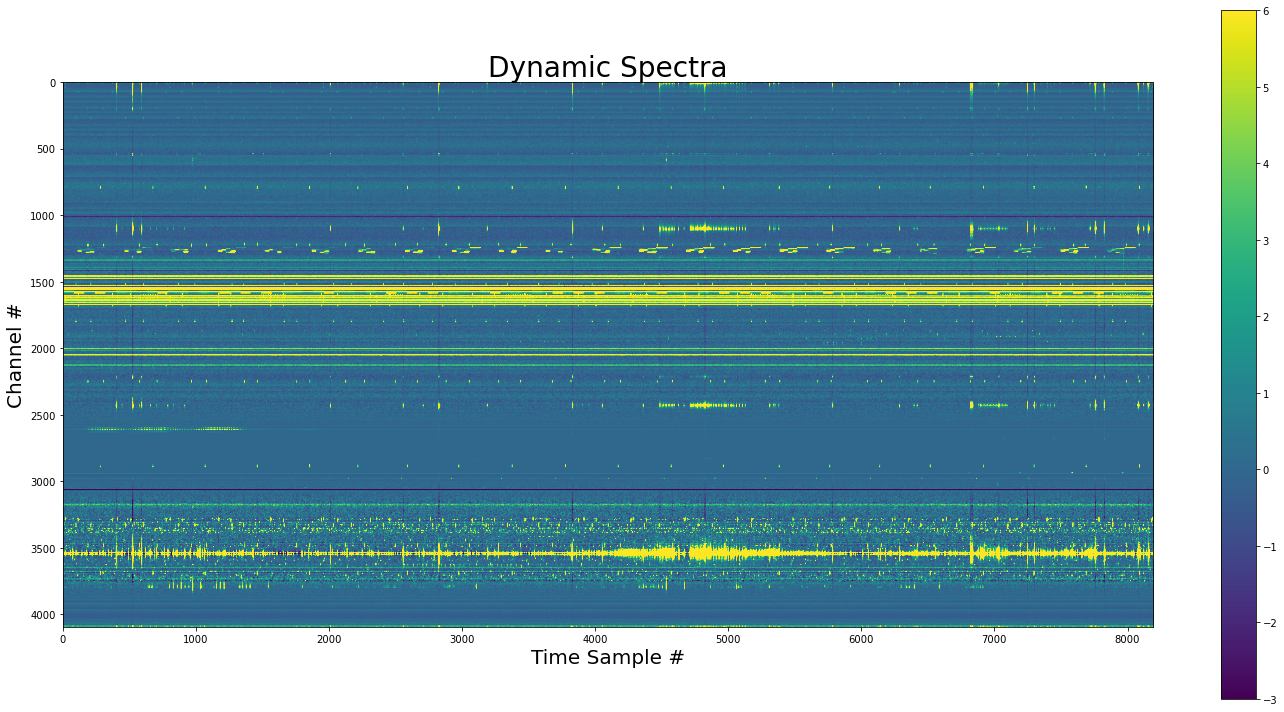

In [5]:
# Show the base dynamic spectra
show_dynamic(dynamic_spectra, title="Dynamic Spectra")

## Find a bandpass to scale the frequency structure

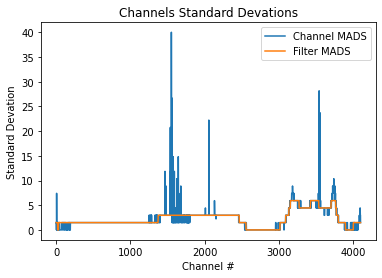

In [6]:
plt.title("Channels Standard Devations")
plt.xlabel("Channel #")
plt.ylabel("Standard Devation")
mads = median_abs_deviation(dynamic_spectra, axis=0, scale="normal")
plt.plot(mads, label="Channel MADS")
mads_smooth = median_fitter(mads, chans_per_fit=100)
plt.plot(mads_smooth, label="Filter MADS")
plt.legend()

## Create the pulse

In [7]:
dm = 200
pulse = create.create_gauss_pulse(
    nsamp=int(3e5),
    dm=dm,
    tau=20,
    sigma_time=0.001,
    phi=np.pi / 3,
    spectral_index_alpha=0,
    sigma_freq=350,
    center_freq=yr_obj.your_header.center_freq,
    chan_freqs=yr_obj.chan_freqs,
    tsamp=yr_obj.your_header.tsamp,
    nscint=0,
    bandpass=mads_smooth,
)

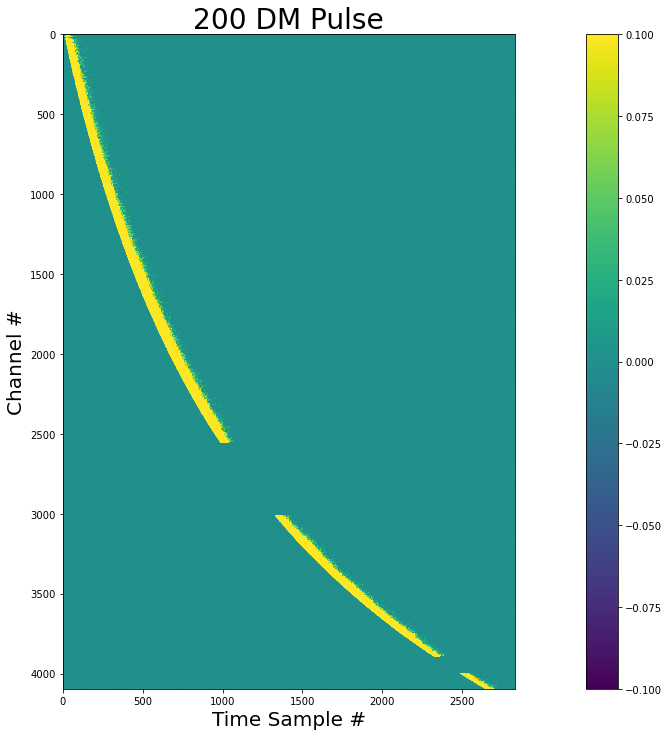

In [8]:
show_dynamic(pulse, title=f"{dm} DM Pulse")

We can see that there is not pulse in areas with zero variance (Like the cavity filter).

## Inject the pulse

In [9]:
dynamic_spectra_w_pulse = inject.inject_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=yr_obj.your_header.nspectra // 2 - 1024,
    gulp=yr_obj.your_header.nspectra,
)

Output()

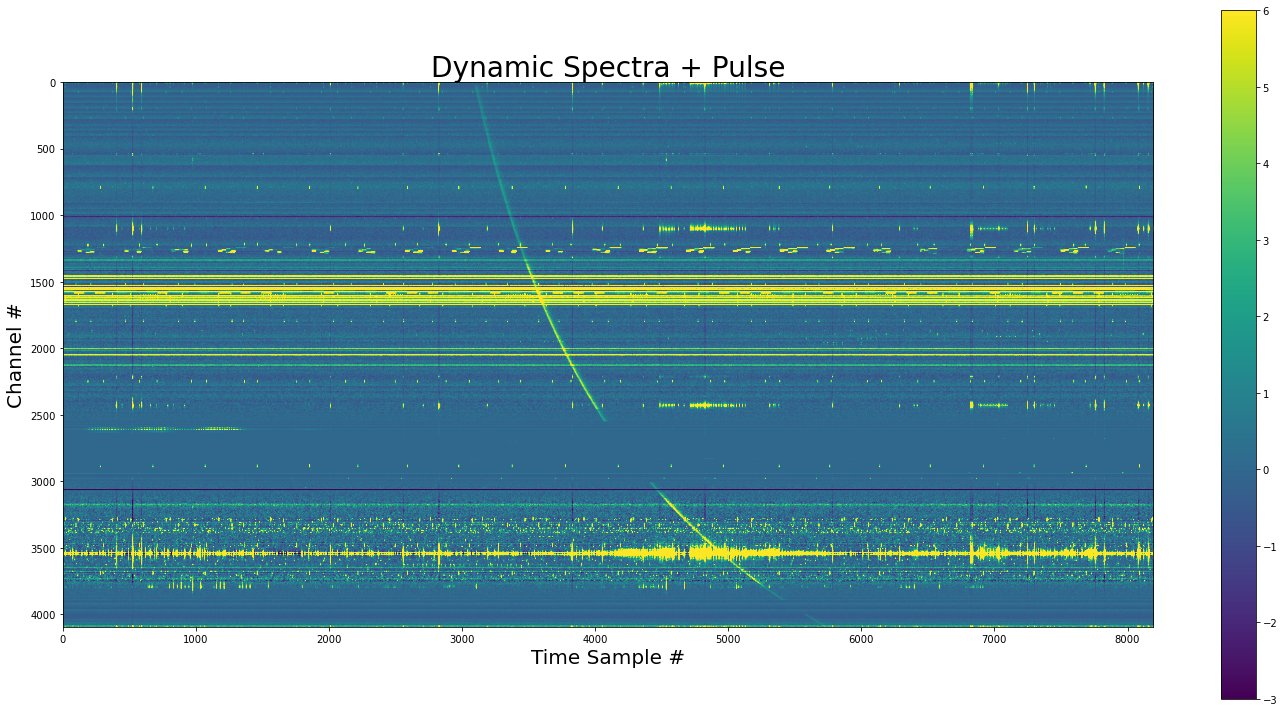

In [10]:
show_dynamic(dynamic_spectra_w_pulse, title="Dynamic Spectra + Pulse")

The pulse added to the dynamic spectra. We see that the pulse doesn't exist where the channel variances are zero.

In [11]:
dynamic_spectra_w_pulse_perodic = inject.inject_into_file(
    yr_input=yr_obj,
    pulse=pulse,
    start=0,
    period=1234,
    gulp=yr_obj.your_header.nspectra,
)

Output()

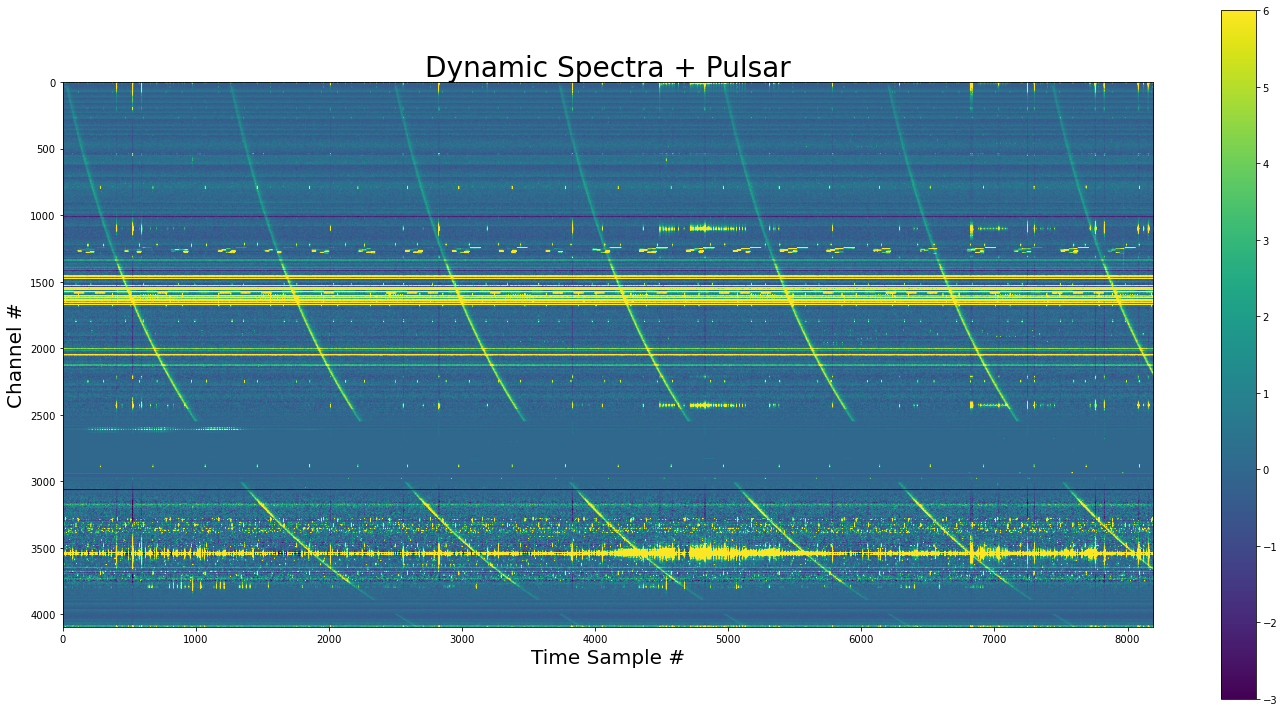

In [12]:
show_dynamic(dynamic_spectra_w_pulse_perodic, title="Dynamic Spectra + Pulsar")

Now we have a pulsar with a period of `1234` samples